L'objectif de ce notebook est de :

1. Traiter le jeu de données afin de repérer des variables pertinentes pour les traitements à         venir

2. Automatiser ces traitements pour éviter de répéter ces opérations.


                                SOMMAIRE
 
A -Mise en place de l'environnement python

B -Import de la base de données
 
C -Vue globale et etude préliminaire avec premier nettoyage

D -Choix des variables pertinentes
 
E -Nettoyage des données 
 
F -Etude et conclusions

                                   

In [1]:
                        # MISE EN PLACE DE L'ENVIRONNEMENT PYTHON
                                   
                # Installation des librairies et des fonctions usuelles de python .                                 

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
 

import warnings
warnings.filterwarnings("ignore")

from IPython.display import Image
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
sns.set(style="darkgrid", palette="pastel", color_codes=True)
sns.set_context('talk')

from pathlib import Path
data_dir = Path('../input/images')           
import sklearn
import matplotlib.pyplot as plt
import matplotlib.colors 
import numpy as np 
import pandas as pd 
import seaborn as sns
import scipy.stats as st # perform correlation calculation 
from sklearn.impute import SimpleImputer
from matplotlib.ticker import AutoMinorLocator
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/openclassrooms-projet-3/en.openfoodfacts.org.products.tsv


In [2]:
                                  # Quelques fonctions usuelles de python:

def nb_lines(data):     
    ''' returns number of rows'''
    return len(data)

def nb_columns(data):
    ''' returns number of columns'''
    return len(data.columns)

def missing_cells(data):
    ''' returns number of missing cells'''
    return data.isna().sum().sum()

def missing_cells_percent(data):
    ''' returns percentage of missing cells'''
    return data.isna().sum().sum()/(data.size)

def count_duplicates_rows(data):
    ''' returns number of duplicate rows'''
    return len(data)-len(data.drop_duplicates())

def count_duplicates_rows_percent(data):
    '''  returns percentage of duplicate rows'''
    return count_duplicates_rows(data)/nb_lines(data)

def data_set_overview(data):    
    '''  prints a dataframe summary containing:number of rows, columns, missing cells and duplicate
    rows'''
   
    print('*****************************************************************************************')
    print('Data : {}'.format(namestr(data, globals())))
    print('Number of variables : {}'.format(nb_columns(data)))
    print('Number of observations : {}'.format(nb_lines(data)))
    print('Missing cells : {}'.format(missing_cells(data)))
    print('Missing cells in % : {:.2%}'.format(missing_cells_percent(data)))
    print('Duplicate rows : {}'.format(count_duplicates_rows(data)))
    print('Duplicate rows in % : {:.2%}'.format(count_duplicates_rows_percent(data)))
    return None

def dataset_variables_overview(data):
    '''  returns a summary containing : variable name, type, distinct values, missing values, and
    numerical 
                        statistics for numerical variables '''
    print('*****************************************************************************************')
    print('Data : {}'.format(namestr(data, globals())))
    print('*****************************************************************************************')
    df = pd.DataFrame(columns=['Variable name','Variable type','Distinct','% distinct','Missing',
                               '% missing', 'Mean', 'Median', 'Skew', 'Kurtosis', 'Variance', 
                               'Stdev', 'min','25%','50%','75%','max'])
    for column in data.columns:
        var_type = data[column].dtypes
        distinct = len(data[column].unique())
        percent_distinct = len(data[column].unique())/len(data[column])
        missing = missing_cells(data[column])
        percent_missing = missing_cells_percent(data[column])
        if var_type != 'object':    
             df = df.append(pd.DataFrame([[column,var_type,distinct,percent_distinct,missing,
                                           percent_missing,
                                           data[column].mean(),data[column].median(),
                                           data[column].skew(),
                                           data[column].kurtosis(),data[column].var(ddof=0),
                                          data[column].std(ddof=0),data[column].min(),
                                           data[column].quantile(0.25),
                                           data[column].quantile(0.5),data[column].quantile(0.75),
                                           data[column].max()]], 
                                         columns=['Variable name','Variable type','Distinct',
                                                  '% distinct','Missing',
                                                 '% missing', 'Mean', 'Median', 'Skew', 'Kurtosis',
                                                  'Variance', 'Stdev',
                                                  'min','25%','50%','75%','max']))
        else:            
            df = df.append(pd.DataFrame([[column,var_type,distinct,percent_distinct,missing,
                                          percent_missing,
                                          '','','','','','','','','','','']], 
                                        columns=['Variable name','Variable type',
                                    'Distinct','% distinct', 'Missing','% missing', 'Mean', 'Median',
                                                 'Skew', 'Kurtosis',
                                                             'Variance', 'Stdev', 'min','25%','50%',
                                                 '75%','max']))
    return df
            
def output_dataset_variables_overview(data):
    '''output to csv files the variables overview '''
    summary = dataset_variables_overview(data)
    summary.to_csv('output_dataset_variables_overview.csv',sep=',', index = False)
    
def dataset_columns(data):
    ''' prints variables in dataframe'''
    print('*******************************************************************************')
    print('Data : {}'.format(namestr(data, globals())))
    print('Columns : {}'.format(data.columns.values))

def namestr(obj, namespace):
    '''  returns variable name in namespace '''
    return [name for name in namespace if namespace[name] is obj]

# Histogram of column data
def plotHistogram(df, nHistogramShown, nHistogramPerRow):
    ''' function taking a dataframe df, and two integers as number of histograms shown and number
    of histograms per row '''
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, 
                                                          # pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nHistRow = (nCol + nHistogramPerRow - 1) / nHistogramPerRow
    plt.figure(num=None, figsize=(6*nHistogramPerRow, 8*nHistRow), dpi=80, facecolor='w', 
               edgecolor='k')
    for i in range(min(nCol, nHistogramShown)):
        plt.subplot(nHistRow, nHistogramPerRow, i+1)
        df.iloc[:,i].hist()
        plt.ylabel('counts')
        plt.xticks(rotation=90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
    plt.show()
    
def is_in_vector(string,vector):
    ''' function that takes a strings and tests if it is present in argument vector '''
    resp = False
    for entry in vector:
        if string == entry:
            resp = True    
    return resp

def columns_type(data): 
    '''  returns a dataframe with data's variable names and types '''
    df = pd.DataFrame(data.dtypes)[0]
    summary = pd.DataFrame(columns=['Variable name', 'Variable type'])
    summary['Variable name']=data.columns
    summary['Variable type']=list(df)
    return summary

def output_dataframe_variable_types(data):
    ''' function that outputs columns_type method's output in csv file '''
    summary = columns_type(data)
    summary.to_csv('output_dataframe_variable_types.csv',sep=',', index = False)

def missing_values(data):
    ''' function that takes dataframe as input and output a dataframe containing variables, 
    number of missing values 
    and % of missing'''
    summary = pd.DataFrame(columns=['Variable name', 'Missing values', '% Missing'])
    summary['Variable name']=data.columns
    missing = list()
    percent_missing = list()
    for var in data.columns:
        nb_missing = missing_cells(data[var])
        pc_missing = missing_cells_percent(data[var])
        missing.append(nb_missing)
        percent_missing.append(pc_missing)
    summary['Missing values'] = list(missing)
    summary['% Missing'] = list(percent_missing)
    return summary
    
def output_dataframe_missing_values_summary(data):
    ''' function that outputs missing_values method's output in csv file '''
    summary = missing_values(data)
    summary.to_csv('dataframe_missing_values_summary.csv',sep=',', index = False)
       
def summarize_cat_var(variable,data):
    ''' function that takes a categorical variable and data returns a dataframe summarizing
    modalities count, nb uniques,
    top, less'''
    nb_modalities = len(data[variable].unique())
    count = len(data[variable])
    index = pd.DataFrame(ed_stats_data.groupby(['Country Code'], sort = True).count()).index
    top = index[0]
    less = index[len(index)-1]
    summary = pd.DataFrame(columns=('Variable name','Nb Modalities', 'Count','Top','Less'))  
    summary['Variable name'] = [variable]
    summary['Nb Modalities'] = [nb_modalities]
    summary['Count'] = [count]
    summary['Top'] = [top]
    summary['Less'] = [less]
    return summary

def output_summarize_cat_var(variable,data):
    ''' function that outputs summarize_cat_var method's output in csv file '''
    summary = summarize_cat_var(variable,data)
    summary.to_csv('output_summarize_cat_var.csv',sep=',', index = False)
    
def dataset_drop_unpopulated_variables(data, limit):
    ''' function that drops variables from data dataframe with more than limit missing data
        limit is a float between 0 and 100'''
    data_temp = pd.DataFrame()
    data_temp = data
    for column in data.columns:        
        var_type = data[column].dtypes
        percent_missing =  missing_cells_percent(data[column])
        if var_type == 'float64' and float(missing_cells_percent(data[column]))>limit:
            print('Dropping variable {} from  {}'.format(column,namestr(data, globals())))
            data_temp = data_temp.drop([column], axis=1)
    return data_temp
def drop_unpopulated_column(data,limit):
    summary = missing_values(data)
    logical = list()
    for row in summary.iterrows():        
        if float(row[1]['% Missing'])>float(limit):
            # to be dropped
            print('Dropping variable {} from  {} with % missing {}'.format(row[1]['Variable name'],
                 namestr(data, globals()),round(float(row[1]['% Missing']),2)))
            logical.append(False)
        else:
            #kept
            logical.append(True)
        
    columns_to_keep = summary[logical]['Variable name']
    
    return data[columns_to_keep]
def dataset_filled_cells_per_line(data,limit):
    ''' function that drops rows from dataframe with less than limit data'''
    return data.dropna(thresh=limit)
def dataset_filled_cells_per_column(data,limit):
    '''function that drops columns from dataframe with lessthan limit data'''
    return data.dropna(axis=1,thresh=limit)
def out_iqr(df , column):
    '''function that gives IQR,lower and upper whisker'''
    global lower,upper
    q25, q75 = np.quantile(df[column], 0.25), np.quantile(df[column], 0.75)
    # calculate the IQR
    iqr = q75 - q25
    # calculate the outlier cutoff
    cut_off = iqr * 3
    # calculate the lower and upper bound value
    lower, upper = q25 - cut_off, q75 + cut_off
    print('The IQR is',iqr)
    print('The lower bound value is', lower)
    print('The upper bound value is', upper)
    # Calculate the number of records below and above lower and above bound value respectively
    df1 = df[df[column] > upper]
    df2 = df[df[column] < lower]
    return print('Total number of outliers are', df1.shape[0]+ df2.shape[0])

from scipy import stats

def drop_numerical_outliers(df, z_thresh=3):
    # Constrains will contain `True` or `False` depending on if it is a value below the threshold.
    constrains = df.select_dtypes(include=[np.number]) \
    .apply(lambda x: np.abs(stats.zscore(x)) < z_thresh, reduce = False) \
    .all(axis=1)
    # Drop (inplace) values set to be rejected
    df.drop(df.index[~constrains], inplace=True)

def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-3*iqr
    fence_high = q3+3*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]    

In [3]:
                                                    # Import des données

main_data = pd.read_csv('../input/openclassrooms-projet-3/en.openfoodfacts.org.products.tsv', 
                        sep='\t', error_bad_lines=False, low_memory=False)

In [4]:
                                           # Vue globale et nettoyage preliminaire
# global dataset overview

data_set_overview(main_data)

*****************************************************************************************
Data : ['main_data']
Number of variables : 163
Number of observations : 356027
Missing cells : 44183489
Missing cells in % : 76.14%
Duplicate rows : 0
Duplicate rows in % : 0.00%


In [5]:
# number of lines in dataset
nb_lines(main_data)

356027

In [6]:
# number of columns of dataset
nb_columns(main_data)

163

In [7]:
# types of variables in dataset

columns_type(main_data)

,Variable name,Variable type
0,code,object
1,url,object
2,creator,object
3,created_t,object
4,created_datetime,object
...,...,...
158,carbon-footprint_100g,float64
159,nutrition-score-fr_100g,float64
160,nutrition-score-uk_100g,float64
161,glycemic-index_100g,float64


In [8]:
# output of variables types in csv
output_dataframe_variable_types(main_data)

In [9]:
# pourcentage des données manquantes
missing_values(main_data)

,Variable name,Missing values,% Missing
0,code,26,0.000073
1,url,26,0.000073
2,creator,3,0.000008
3,created_t,3,0.000008
4,created_datetime,10,0.000028
...,...,...,...
158,carbon-footprint_100g,355749,0.999219
159,nutrition-score-fr_100g,101171,0.284167
160,nutrition-score-uk_100g,101171,0.284167
161,glycemic-index_100g,356027,1.000000


In [10]:
# output du pourcentage des données manquantes en csv
output_dataframe_missing_values_summary(main_data)


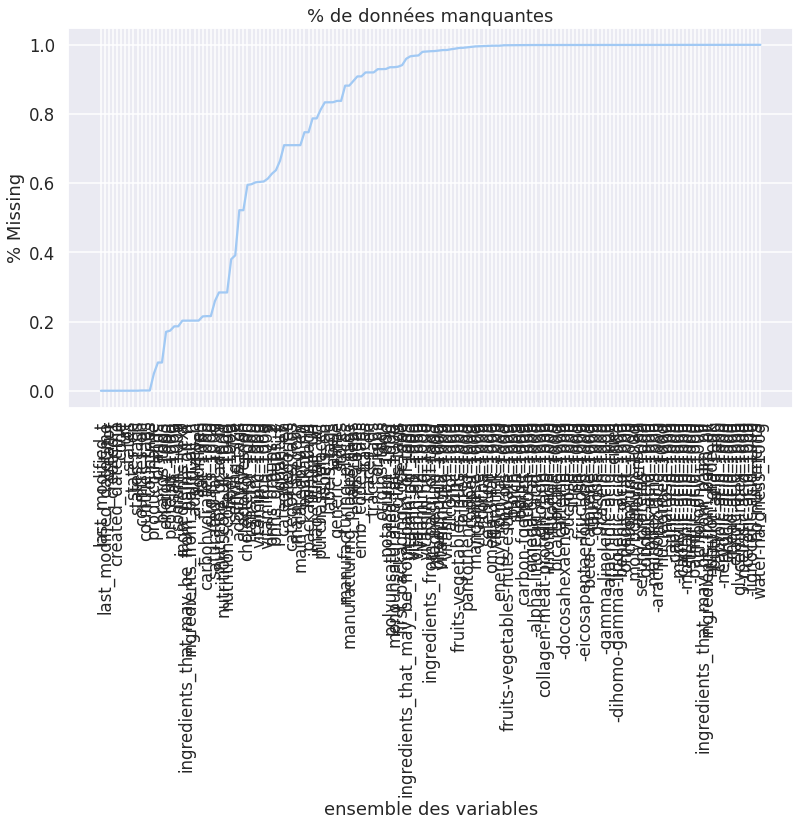

In [11]:
# % missing data visualization

to_plot = missing_values(main_data).sort_values(by=['% Missing'])

fig = plt.figure(figsize=(13, 7))
ax = plt.axes()
degrees = 90
plt.xticks(rotation=degrees)
plt.title('% de données manquantes')
plt.ylabel('% Missing')
plt.xlabel('ensemble des variables')
plt.plot(to_plot['Variable name'],to_plot['% Missing']);

In [12]:
# analyse des variables et choix des variables pertinentes
dataset_variables_overview(main_data)


*****************************************************************************************
Data : ['main_data']
*****************************************************************************************


,Variable name,Variable type,Distinct,% distinct,Missing,% missing,Mean,Median,Skew,Kurtosis,Variance,Stdev,min,25%,50%,75%,max
0,code,object,356002,0.999930,26,0.000073,,,,,,,,,,,
0,url,object,356002,0.999930,26,0.000073,,,,,,,,,,,
0,creator,object,3891,0.010929,3,0.000008,,,,,,,,,,,
0,created_t,object,224752,0.631278,3,0.000008,,,,,,,,,,,
0,created_datetime,object,224753,0.631281,10,0.000028,,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,carbon-footprint_100g,float64,205,0.000576,355749,0.999219,335.790664,190.95,2.748317,10.221762,178491.800304,422.482899,0.0,82.65,190.95,378.7,2842.0
0,nutrition-score-fr_100g,float64,56,0.000157,101171,0.284167,9.166137,10.0,0.114949,-1.00689,80.997334,8.999852,-15.0,1.0,10.0,16.0,40.0
0,nutrition-score-uk_100g,float64,56,0.000157,101171,0.284167,8.980656,9.0,0.150212,-1.073935,83.754319,9.151739,-15.0,1.0,9.0,16.0,40.0
0,glycemic-index_100g,float64,1,0.000003,356027,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# output du dataset _variables_overview en csv
output_dataset_variables_overview(main_data)

*****************************************************************************************
Data : ['main_data']
*****************************************************************************************


In [14]:
main_data = main_data.fillna(main_data.mode())
main_data.head(5)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,Pâtes alimentaires au blé dur de qualité supér...,1kg,...,0.0,100.0,15.0,30.0,NaN,0.0,0.0,0.0,NaN,NaN
1,0000000004530,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,0000000016087,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,0000000016094,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


                                        Nettoyage du dataset
                                        
      pour nettoyer mon dataset ,j'adopte la methode qui consiste à eliminer les colonnes avec un missing cell percentage inférieur à 85 %                                   

In [15]:
finalset_data = drop_unpopulated_column(main_data,0.90)

Dropping variable origins from  ['main_data'] with % missing 0.93
Dropping variable origins_tags from  ['main_data'] with % missing 0.93
Dropping variable emb_codes from  ['main_data'] with % missing 0.91
Dropping variable emb_codes_tags from  ['main_data'] with % missing 0.91
Dropping variable first_packaging_code_geo from  ['main_data'] with % missing 0.94
Dropping variable cities from  ['main_data'] with % missing 1.0
Dropping variable cities_tags from  ['main_data'] with % missing 0.94
Dropping variable allergens_en from  ['main_data'] with % missing 1.0
Dropping variable traces from  ['main_data'] with % missing 0.92
Dropping variable traces_tags from  ['main_data'] with % missing 0.92
Dropping variable traces_en from  ['main_data'] with % missing 0.92
Dropping variable no_nutriments from  ['main_data'] with % missing 1.0
Dropping variable ingredients_from_palm_oil from  ['main_data'] with % missing 1.0
Dropping variable ingredients_from_palm_oil_tags from  ['main_data'] with % mi

In [16]:
data_set_overview(finalset_data)

*****************************************************************************************
Data : ['finalset_data']
Number of variables : 63
Number of observations : 356027
Missing cells : 8873082
Missing cells in % : 39.56%
Duplicate rows : 0
Duplicate rows in % : 0.00%


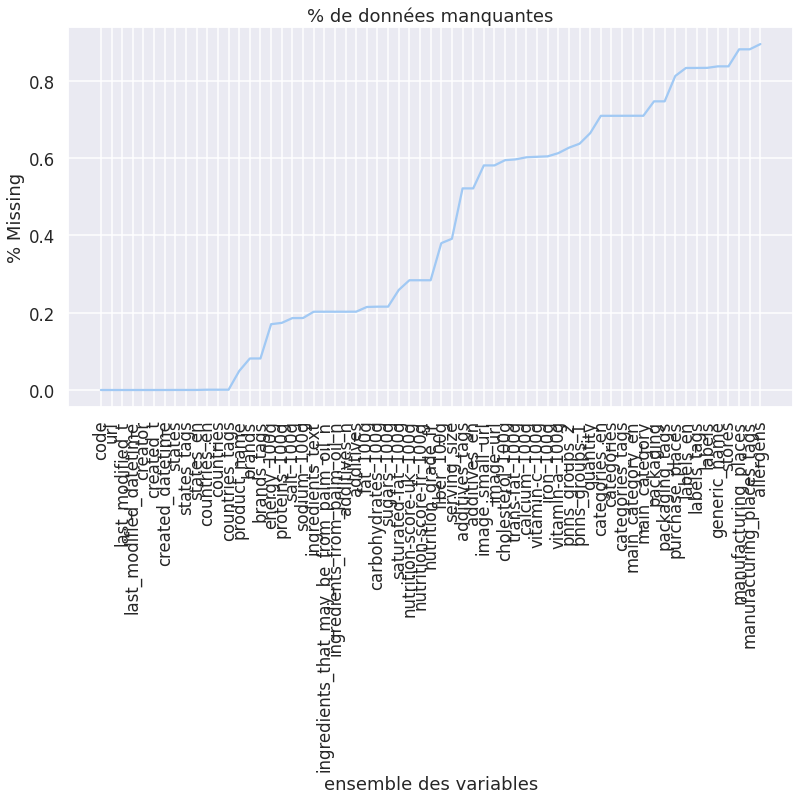

In [17]:
# %  new missing data visualization

to_plot = missing_values(finalset_data).sort_values(by=['% Missing'])

fig = plt.figure(figsize=(13, 7))
ax = plt.axes()
degrees = 90
plt.xticks(rotation=degrees)
plt.title('% de données manquantes')
plt.ylabel('% Missing')
plt.xlabel('ensemble des variables')
plt.plot(to_plot['Variable name'],to_plot['% Missing']);

In [18]:

# output of missing values summary for finalset_data

output_dataframe_missing_values_summary(finalset_data)

In [19]:
# interessons nous aux variables:
# we set index to product name for convenience

finalset_data.set_index('product_name',inplace=True)




In [20]:
# we remove the $ special character and a product named 0

finalset_data = finalset_data.replace('$','')

In [21]:
# We choose to fill missing data with 0 rather than drop entire line

finalset_data = finalset_data.fillna(0)


In [22]:
# output to csv dataframe variables types
output_dataframe_variable_types(finalset_data)

In [23]:
finalset_data.columns

Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'generic_name', 'quantity',
       'packaging', 'packaging_tags', 'brands', 'brands_tags', 'categories',
       'categories_tags', 'categories_en', 'manufacturing_places',
       'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_en',
       'purchase_places', 'stores', 'countries', 'countries_tags',
       'countries_en', 'ingredients_text', 'allergens', 'serving_size',
       'additives_n', 'additives', 'additives_tags', 'additives_en',
       'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'nutrition_grade_fr',
       'pnns_groups_1', 'pnns_groups_2', 'states', 'states_tags', 'states_en',
       'main_category', 'main_category_en', 'image_url', 'image_small_url',
       'energy_100g', 'fat_100g', 'saturated-fat_100g', 'trans-fat_100g',
       'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
       'pro

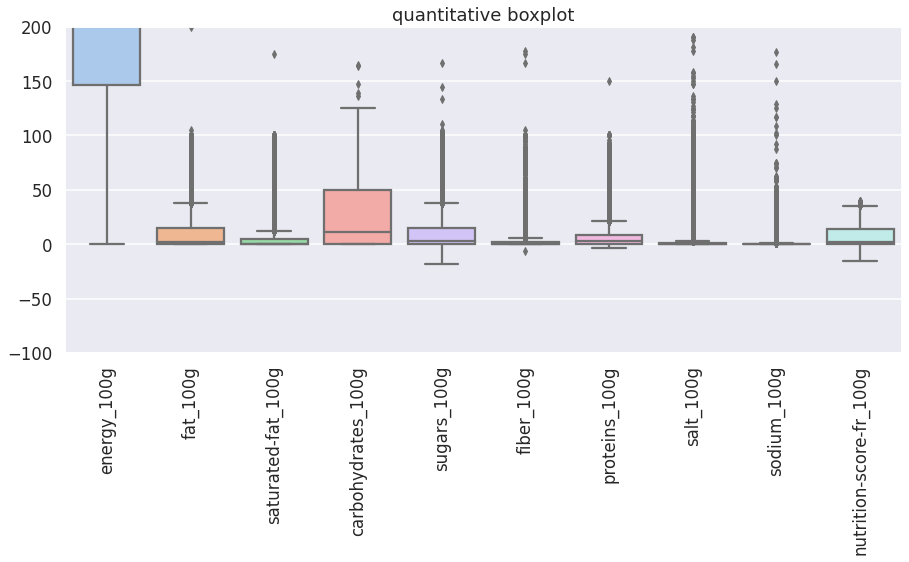

In [24]:
# interessons nous aux variables quantitatives qui sont les plus pertinentes:
quant_variables = [ 'energy_100g', 'fat_100g', 'saturated-fat_100g',
         'carbohydrates_100g','sugars_100g', 'fiber_100g', 'proteins_100g',
         'salt_100g','sodium_100g',  'nutrition-score-fr_100g']

import seaborn as sns
import matplotlib.pyplot as plt

degrees = 90

fig = plt.figure(figsize=(15, 6))
ax = plt.axes()
plt.xticks(rotation=degrees)
ax.set_ylim([-1e2,2e2])
sns.boxplot(data=finalset_data[quant_variables]).set_title('quantitative boxplot');

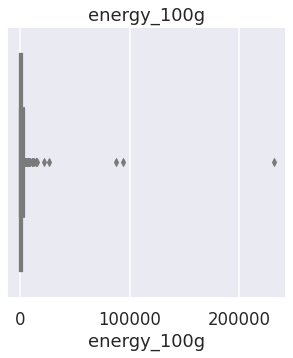

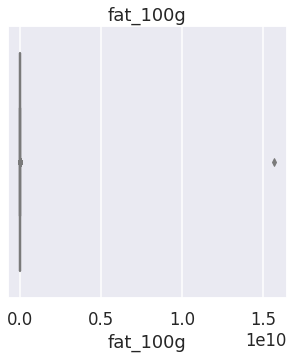

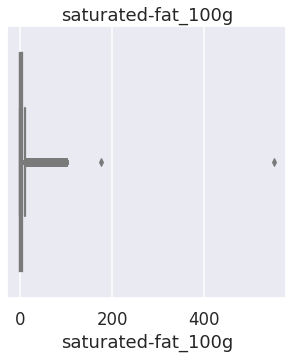

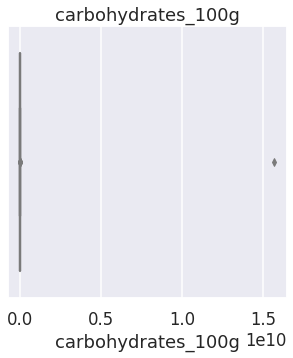

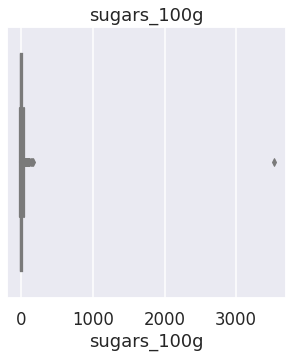

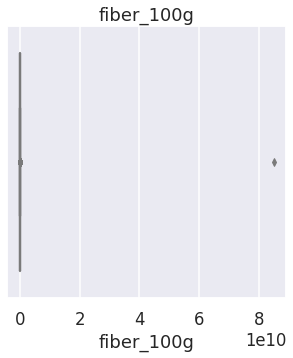

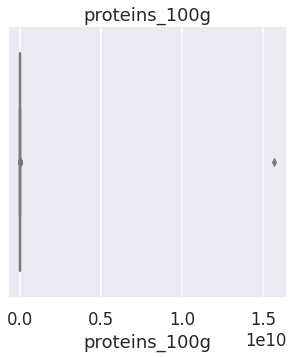

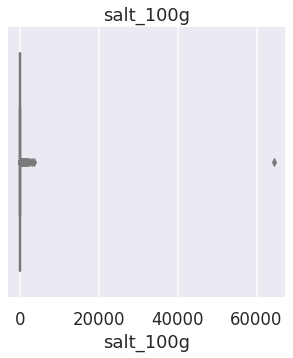

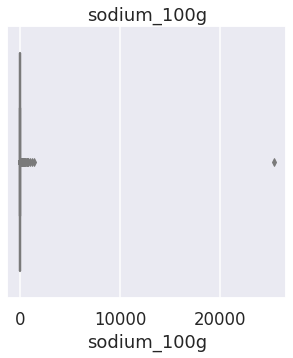

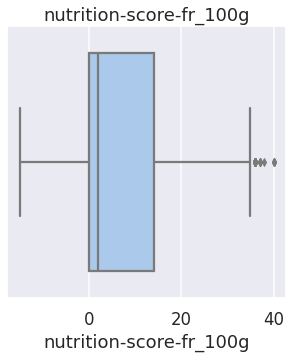

In [25]:
for data in quant_variables:
    plt.figure(figsize=(5,5));
    sns.boxplot(x=finalset_data[data]).set_title(data);

In [26]:
# dataframe without outliers: enlevons les outliers par la methode des interquartiles

for data in quant_variables:
    out_iqr(finalset_data,data);
    finalset_data = finalset_data.loc[(finalset_data[data]<upper) & (finalset_data[data]>lower)];

The IQR is 1423.0
The lower bound value is -4123.0
The upper bound value is 5838.0
Total number of outliers are 31
The IQR is 15.04
The lower bound value is -45.12
The upper bound value is 60.16
Total number of outliers are 6728
The IQR is 4.17
The lower bound value is -12.51
The upper bound value is 16.68
Total number of outliers are 20012
The IQR is 50.0
The lower bound value is -150.0
The upper bound value is 200.0
Total number of outliers are 2
The IQR is 14.0
The lower bound value is -42.0
The upper bound value is 56.0
Total number of outliers are 17558
The IQR is 2.3
The lower bound value is -6.8999999999999995
The upper bound value is 9.2
Total number of outliers are 12898
The IQR is 7.9
The lower bound value is -23.700000000000003
The upper bound value is 31.6
Total number of outliers are 2724
The IQR is 1.11252
The lower bound value is -3.33756
The upper bound value is 4.45008
Total number of outliers are 9997
The IQR is 0.4
The lower bound value is -1.2000000000000002
The upp

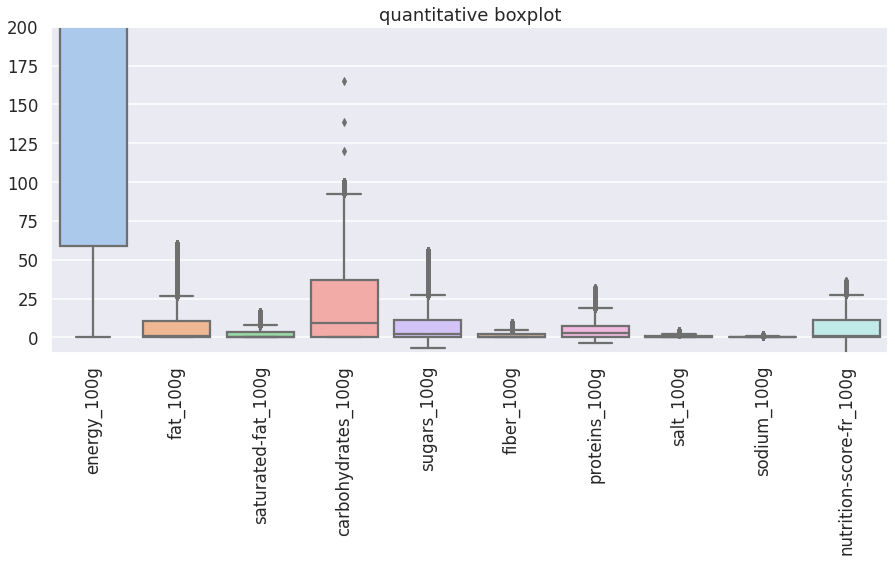

In [27]:
# voyons le graphe de nouveau

degrees = 90
fig = plt.figure(figsize=(15, 6))
ax = plt.axes()
plt.xticks(rotation=degrees)
ax.set_ylim([-1e1,2e2])
sns.boxplot(data=finalset_data[quant_variables]).set_title('quantitative boxplot');

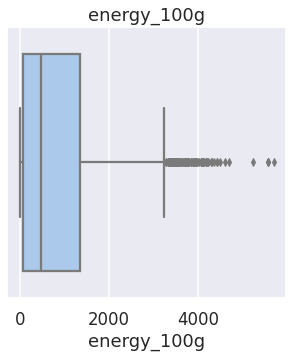

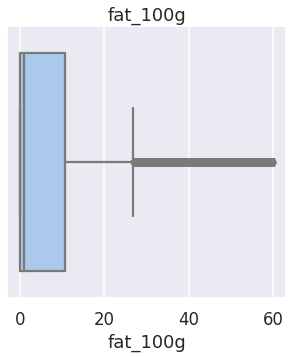

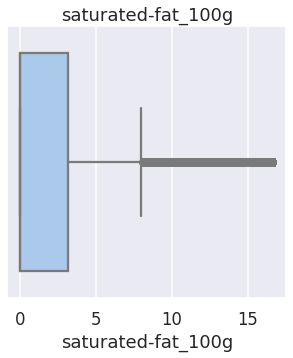

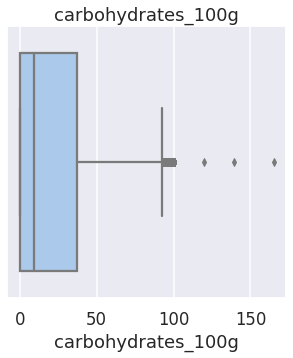

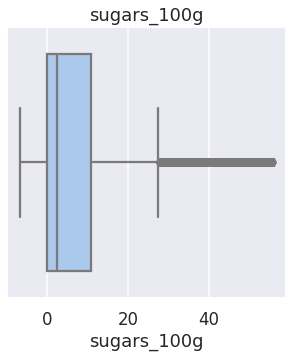

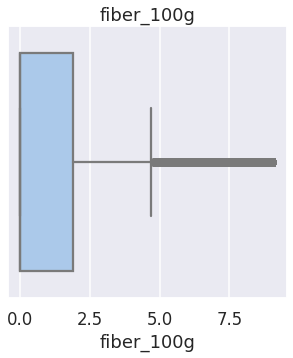

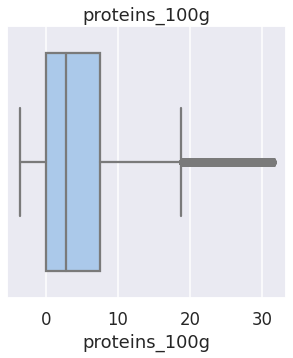

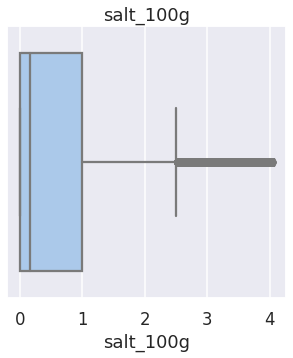

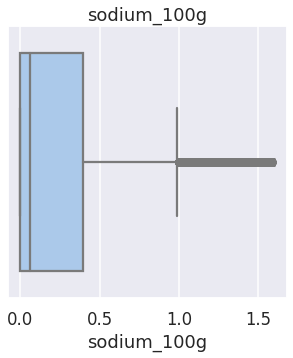

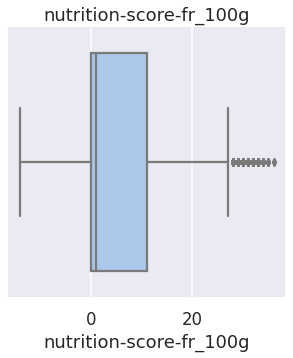

In [28]:
# ainsique les boxplot
for data in quant_variables:
    plt.figure(figsize=(5,5));
    sns.boxplot(x=finalset_data[data]).set_title(data);

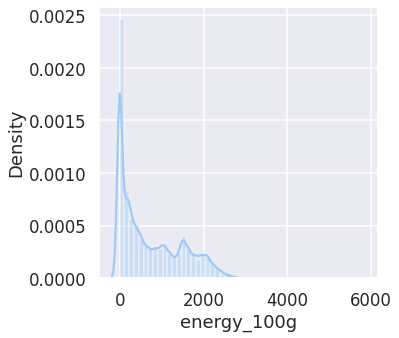

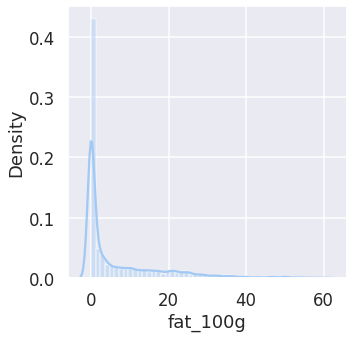

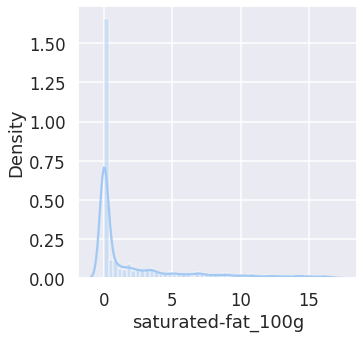

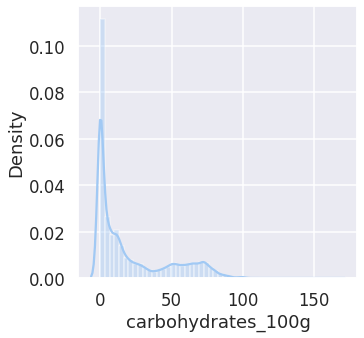

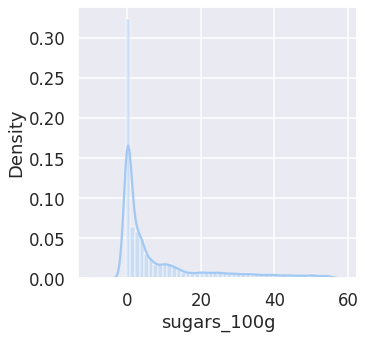

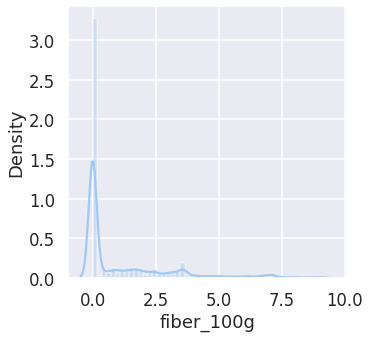

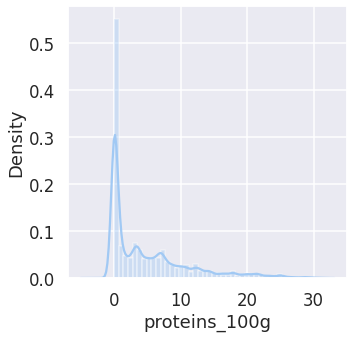

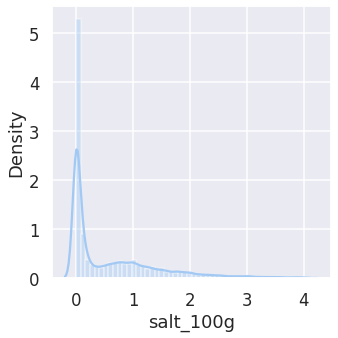

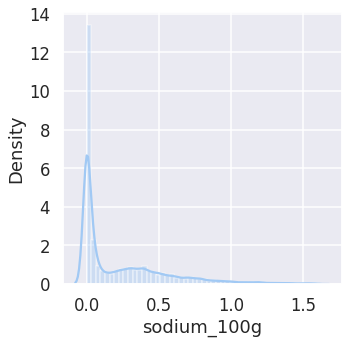

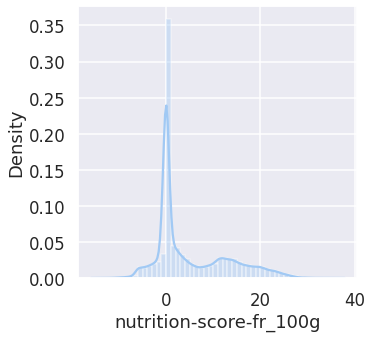

In [29]:
#ainsi que les distplots

for data in quant_variables:
    plt.figure(figsize = (5,5))
    sns.distplot(finalset_data[data])


In [30]:
data_set_overview(finalset_data)

*****************************************************************************************
Data : ['finalset_data']
Number of variables : 62
Number of observations : 284137
Missing cells : 0
Missing cells in % : 0.00%
Duplicate rows : 0
Duplicate rows in % : 0.00%


In [31]:
finalset_data.to_csv('../data/data_cleaned.csv',sep = ',',index = True)

 Conclusion : voici notre base nettoyée selon les approximations les plus larges avec les variables les plus pertinentes.
 ce qui nous donne une base prête à l'exploration et l'analyse .